In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

from LCA import LCA

from network_visualization import Grapher

## Read data

In [2]:
columns = ["congestive_heart_failure", "cardiac_arrhythmia", "valvular_disease", "pulmonary_circulation_disorder", "peripheral_vascular_disorder", "hypertension_uncomplicated", "hypertension_complicated", "paralysis", "other_neurological_disorder", "chronic_pulmonary_disease", "diabetes_uncomplicated", "diabetes_complicated", "hypothyroidism", "renal_failure", "liver_disease", "peptic_ulcer_disease_excluding_bleeding", "aids_hiv", "lymphoma", "metastatic_cancer", "solid_tumor_wo_metastasis", "rheumatoid_arhritis", "coagulopathy", "obesity", "weight_loss", "fluid_and_electrolyte_disorders", "blood_loss_anemia", "deficiency_anemia", "alcohol_abuse", "drug_abuse", "psychoses", "depression"]
columns = ["CHF", "Arrhythmia", "Valvular disease", "Pulmonary circulation disorder", "Peripheral vascular disorder", "Uncomplicated hypertension", "Complicated hypertension", "Paralysis", "Other neurological disorder", "COPD", "Uncomplicated diabetes", "Complicated diabetes", "Hypothyroidism", "Renal failure", "Liver disease", "Peptic ulcer disease", "AID/HIV", "Lymphoma", "Metastatic cancer", "Solid tumor (no metastasis)", "Rheumatoid arthritis", "Coagulopathy", "Obesity", "Weight loss", "Fluid and electrolyte disorders", "Blood loss anemia", "Deficiency anemia", "Alcohol abuse", "Drug abuse", "Psychoses", "Depression"]
# Pandas doesn't seem to support column names with underscores

In [3]:
df1 = pd.read_excel("data/merged_elix_formatted.xlsx") # Spreadsheet with only elix groupings 


In [4]:
print(df1.shape)

(2981, 31)


In [17]:
print(df1.shape)
# df1 = df1[df1.sum(axis=1)!=0] # Remove empty rows?
# print(df1.shape)
data = df1.to_numpy()

(2981, 31)


## Generate data

In [ ]:
columns = ["C1","C2","C3","C4"]
true_theta = [
    [0.1,0.4,0.9,0.2],
    [0.5,0.9,0.1,0.1],
    [0.9,0.9,0.5,0.9]
]
true_weights = [0.1, 0.5, 0.4]
N = 10000

data = []
for tw,tt in zip(true_weights,true_theta):
    data.append(stats.bernoulli.rvs(p=tt, size=(int(tw*N),len(tt))).tolist())
    
data = np.concatenate(data)

In [ ]:
print(data, type(data))

## Apply LCA algorithm

In [62]:
classes = 8
lca = LCA(n_components=classes, tol=1e-10, max_iter=1000)
lca.fit(data)
print(lca.weight)

[0.01886407 0.27993776 0.08285796 0.01384965 0.1077437  0.39445854
 0.04448785 0.05780047]


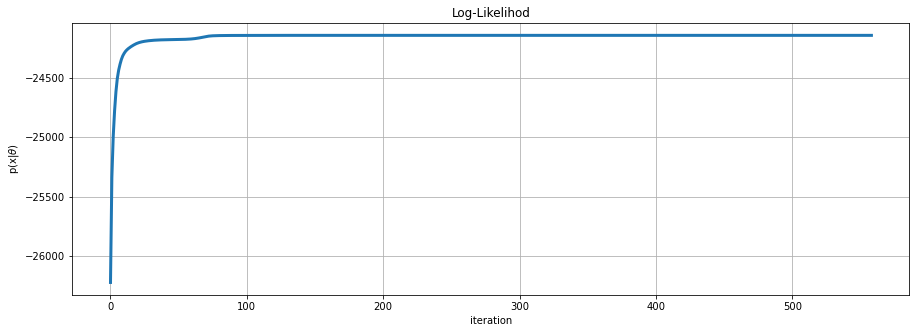

In [6]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(lca.ll_[1:], linewidth=3)
ax.set_title("Log-Likelihod")
ax.set_xlabel("iteration")
ax.set_ylabel(r"p(x|$\theta$)")
ax.grid(True)

## Plot results

In [ ]:
fig, axs = plt.subplots(nrows=lca.theta.shape[0], figsize=(15,lca.theta.shape[0]*10))
axs = axs.ravel()
for i,ax in enumerate(axs):
    ax.bar(range(len(columns)),lca.theta[i,:]) # Single colon in index means fetch everything
    ax.set_xticks(range(len(columns)))
    ax.set_xticklabels(columns, rotation="vertical")
    ax.set(xlabel = "Elixhauser comorbidity group", ylabel = "Prevalence of elixidity group in latent class",
        title = f"Latent class {i+1}")

In [63]:
lca.theta.shape[0] # Gives number of classes
lca.theta.shape[1] # Gives number of input variables 
probs_classes = [lca.theta[:,i] for i in range(lca.theta.shape[1])] # Returns a list of arrays corresponding to the probabilities of each variable in each class
dict_probs = dict(zip(columns, probs_classes))
print(len(dict_probs))

df_list = [] # Container for DFs containing elixidity distributions for each subgroup 
for i in range(lca.theta.shape[0]):
    entry = pd.DataFrame({
        "Name": columns,
        "Value": lca.theta[i,:]
    }) # Need comprehension to package every value in its own list for DF creation
    df_list.append(entry)
print(df_list)

31
[                               Name     Value
0                               CHF  0.083037
1                        Arrhythmia  0.108999
2                  Valvular disease  0.030600
3    Pulmonary circulation disorder  0.017763
4      Peripheral vascular disorder  0.035437
5        Uncomplicated hypertension  0.585323
6          Complicated hypertension  0.000000
7                         Paralysis  0.000000
8       Other neurological disorder  0.392072
9                              COPD  0.265146
10           Uncomplicated diabetes  0.236217
11             Complicated diabetes  0.000000
12                   Hypothyroidism  0.128121
13                    Renal failure  0.000000
14                    Liver disease  0.000000
15             Peptic ulcer disease  0.000000
16                          AID/HIV  0.000000
17                         Lymphoma  0.017770
18                Metastatic cancer  1.000000
19      Solid tumor (no metastasis)  0.510843
20             Rheumatoid arth

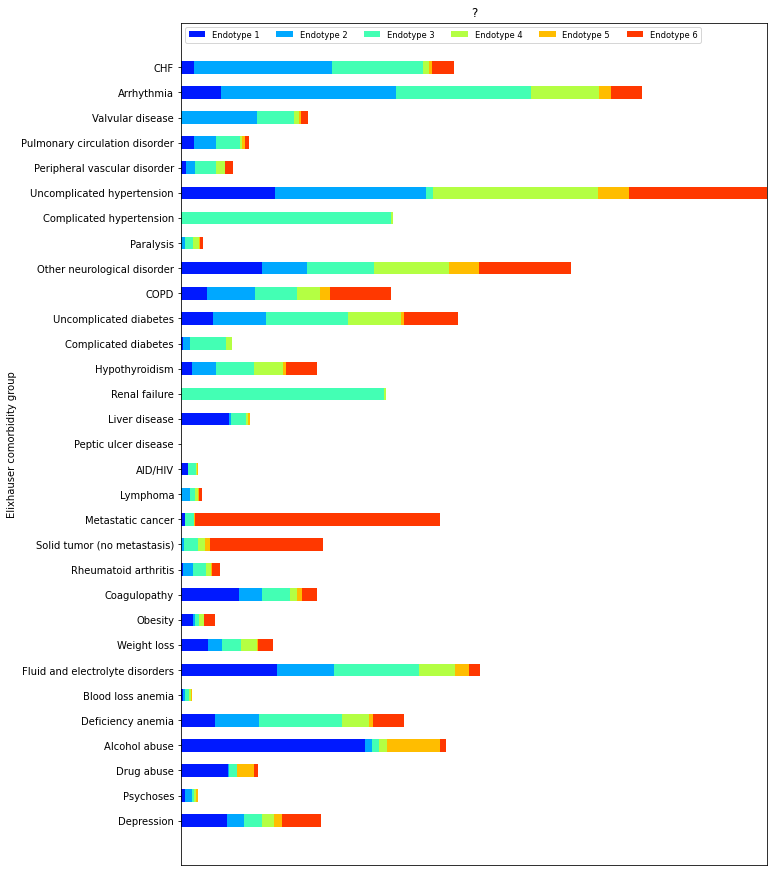

In [32]:
# Discrete distribution horizontal bar chart https://matplotlib.org/stable/gallery/lines_bars_and_markers/horizontal_barchart_distribution.html#sphx-glr-gallery-lines-bars-and-markers-horizontal-barchart-distribution-py
category_names = [f"Endotype {i}" for i in range(1, len(columns)+1)]
results = dict_probs # Dictionary containing comorbidities as keys and its probability distribution across subgroups (categories)


labels = list(results.keys())
data = np.array(list(results.values())) # XXXXXXXXXX This modifies the data variable that's needed later on, should refactor
data_cum = data.cumsum(axis=1)
category_colors = plt.colormaps['RdYlGn'](
    np.linspace(0.15, 0.85, data.shape[1]))
category_colors = plt.colormaps['jet'](
    np.linspace(0.15, 0.85, data.shape[1]))

fig, ax = plt.subplots(figsize=(data.shape[1]*1.75, data.shape[0]*0.5))
ax.invert_yaxis()
ax.xaxis.set_visible(False)
ax.set_xlim(0, np.sum(data, axis=1).max()) # This sets the xlim to the max value
ax.set(
    xlabel = "Prevalence of comorbidity group",
    ylabel = "Elixhauser comorbidity group",
    title = "?"
    )

for i, (colname, color) in enumerate(zip(category_names, category_colors)):
    widths = data[:, i]
    starts = data_cum[:, i] - widths
    rects = ax.barh(labels, widths, left=starts, height=0.5,
                    label=colname, color=color)

    r, g, b, _ = color
    text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
    # ax.bar_label(rects, label_type='center', color=text_color) # Bar labels may be messy if bars are small
ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
            loc='upper left', fontsize='small')

plt.show()

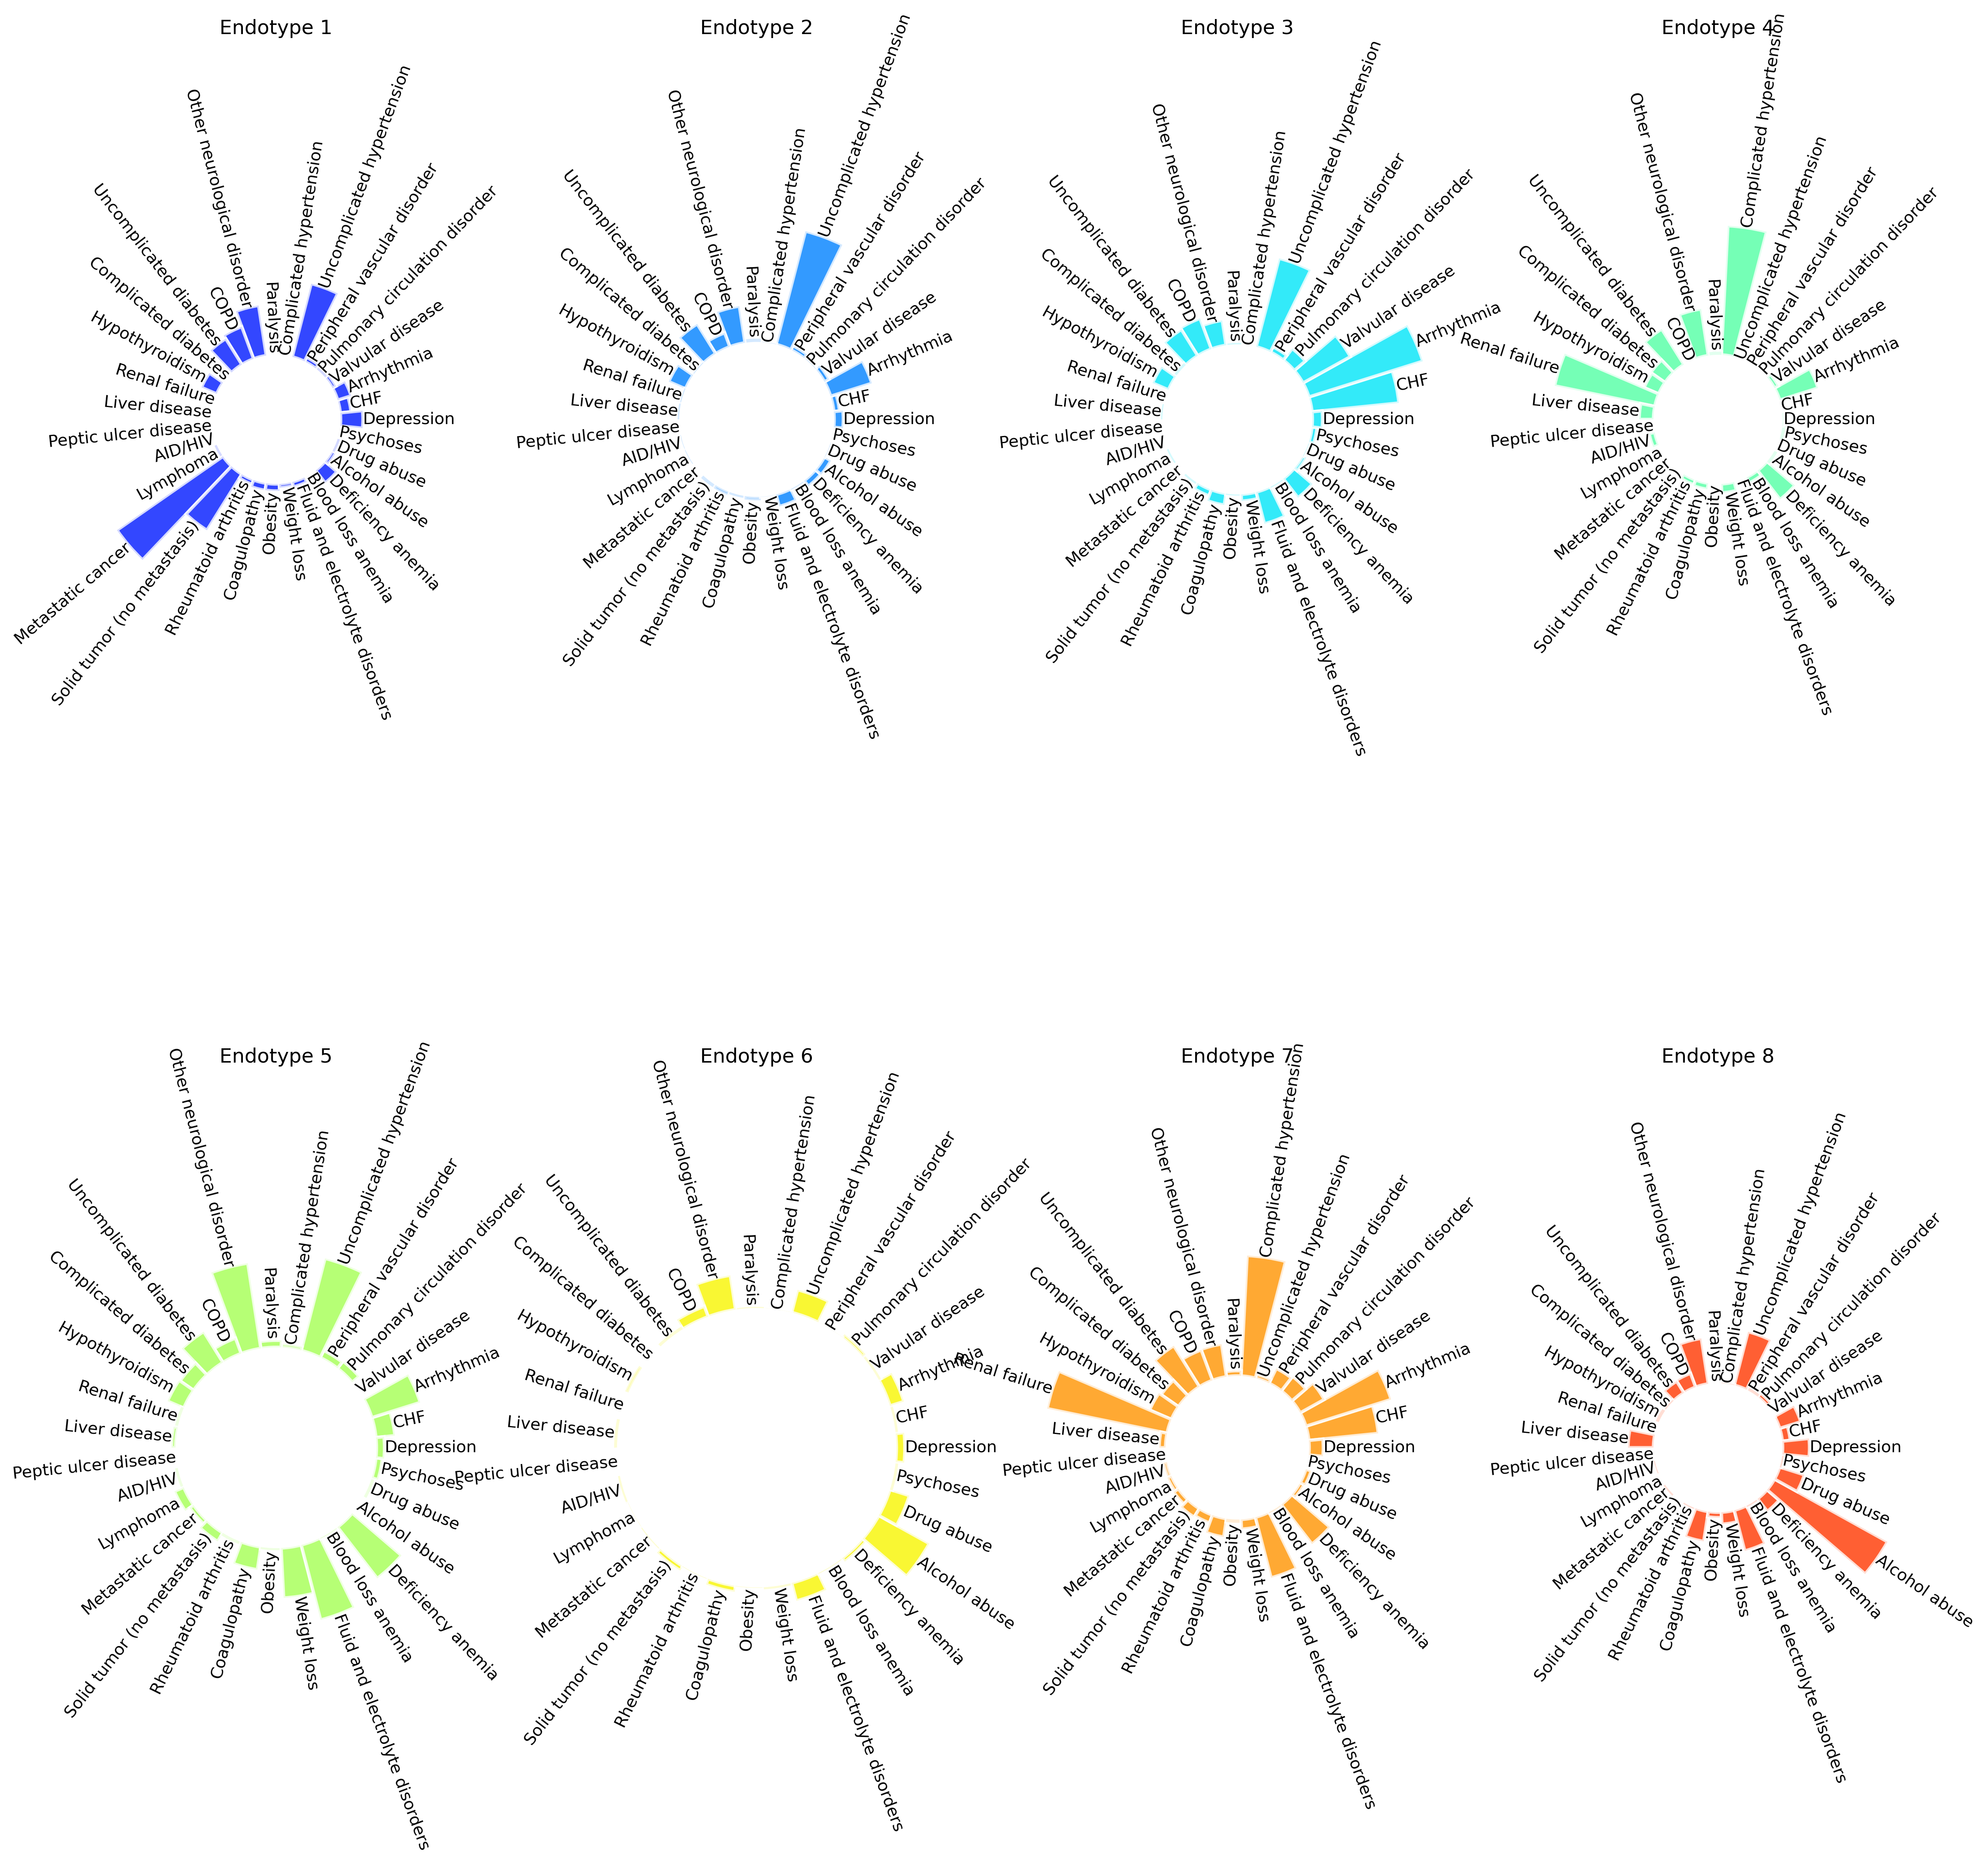

In [64]:
# Radial bar plots
max_height = 100
lower_radius = 50
max_value = 1
category_colors = plt.colormaps['jet'](
    np.linspace(0.15, 0.85, len(df_list)))
fig, axs = plt.subplots(2,4, figsize=(20,21), dpi = 300, subplot_kw={'projection': 'polar'})
axs = axs.ravel()

for index, ax in enumerate(axs):
    df = df_list[index]
    ax.axis('off') # Remove grid
    # max_value = df['Value'].max() # Use for scaling

    # Let's compute heights: they are a conversion of each item value in those new coordinates
    # In our example, 0 in the dataset will be converted to the lowerLimit (10)
    # The maximum will be converted to the upperLimit (100)
    heights = max_height * df.Value/max_value # Returns list of heights

    # Compute the width of each bar. In total we have 2*Pi = 360°
    width = 2*np.pi/len(df.index)

    # Compute the angle each bar is centered on:
    indexes = list(range(1, len(df.index)+1))
    angles = [element * width for element in indexes]

    # Draw bars
    bars = ax.bar(
        x=angles, 
        height=heights, 
        width=width, 
        bottom=lower_radius,
        linewidth=2, 
        edgecolor="#FFFFFFFF",
        color=category_colors[index],
        alpha = 0.8)

    # Add labels
    for bar, angle, height, label in zip(bars,angles, heights, columns):

        # Labels are rotated. Rotation must be specified in degrees :(
        rotation = np.rad2deg(angle)

        # Flip some labels upside down
        alignment = ""
        if angle >= np.pi/2 and angle < 3*np.pi/2:
            alignment = "right"
            rotation = rotation + 180
        else: 
            alignment = "left"

        # Finally add the labels
        ax.text(
            x=angle, 
            y=bar.get_height() + lower_radius,
            s=label, 
            ha=alignment, 
            va='center', 
            rotation=rotation, 
            rotation_mode="anchor") 
    ax.set_title(f"Endotype {str(index+1)}", y = 1.4, pad = 15)


In [65]:
# Generate annotations
data = df1.to_numpy()
df2 = pd.read_excel("data/merged_output_elix_formatted.xlsx") # Merged master spreadsheet with basic clinical info and comorbidity mappings
res = lca.predict(data)
print(res.shape, type(res), res)
entry = pd.DataFrame({"LCA class": res})
print(entry)
# Merge annotations with original df
print(df2.shape)
df2 = pd.concat([df2, entry], axis= 1)
print(df2.shape)
df2.to_excel("data/merged_output_elix_formatted_annotated.xlsx")

(2981,) <class 'numpy.ndarray'> [5 5 5 ... 1 5 4]
      LCA class
0             5
1             5
2             5
3             5
4             5
...         ...
2976          4
2977          7
2978          1
2979          5
2980          4

[2981 rows x 1 columns]
(2981, 39)
(2981, 40)


In [67]:
df3 = pd.read_excel("data/merged_output_elix_formatted_annotated.xlsx")
print(df3["DOD"].count())
num_clusters = 8
df_export = pd.DataFrame()
for i in range(num_clusters): 
    df_sub = df3.loc[df3["LCA class"] == i] # Get all rows of this cluster
    num_rows = df_sub.shape[0]
    print(num_rows)
    dead = df_sub["DOD"].count()
    alive = num_rows - dead
    entry = pd.DataFrame({i: [alive, dead]})
    df_export = pd.concat([df_export, entry], axis = 1)
print(df_export)
df_export.to_excel("data/merged_cluster_mortality.xlsx")

1239
58
869
210
51
236
1268
123
166
    0    1    2   3    4    5   6    7
0  11  428   63  18  115  948  47  112
1  47  441  147  33  121  320  76   54


In [16]:
# Deprecated?
df3 = pd.read_excel("data/merged_elix_formatted_annotated.xlsx")
num_clusters = 7
df_export = pd.DataFrame()
df_list = []
for i in range(num_clusters): 
    print("-------------------")
    df_sub = df3.loc[df3["LCA class"] == i] # Get all rows of this cluster  
    df_sub = df_sub.drop("LCA class", 1) # Drop class column
    print(df_sub.shape)
    num_rows = df_sub.shape[0]
    print(num_rows)
    col_sums = list(df_sub.sum(axis=0))
    print(col_sums, type(col_sums), len(col_sums))
    col_prop = [count/num_rows for count in col_sums]
    print(col_prop, len(col_prop))
    entry = pd.DataFrame({
        "Name": columns,
        "Value": col_prop
    }) # Need comprehension to package every value in its own list for DF creation
    df_list.append(entry)


-------------------
(180, 31)
180
[8, 28, 0, 12, 4, 78, 0, 0, 63, 23, 26, 2, 9, 0, 44, 0, 4, 0, 4, 1, 2, 50, 9, 21, 78, 2, 27, 160, 37, 3, 42] <class 'list'> 31
[0.044444444444444446, 0.15555555555555556, 0.0, 0.06666666666666667, 0.022222222222222223, 0.43333333333333335, 0.0, 0.0, 0.35, 0.12777777777777777, 0.14444444444444443, 0.011111111111111112, 0.05, 0.0, 0.24444444444444444, 0.0, 0.022222222222222223, 0.0, 0.022222222222222223, 0.005555555555555556, 0.011111111111111112, 0.2777777777777778, 0.05, 0.11666666666666667, 0.43333333333333335, 0.011111111111111112, 0.15, 0.8888888888888888, 0.20555555555555555, 0.016666666666666666, 0.23333333333333334] 31
-------------------
(66, 31)
66
[6, 9, 2, 0, 2, 34, 0, 1, 25, 14, 14, 0, 8, 0, 0, 0, 1, 1, 66, 28, 2, 4, 3, 5, 3, 0, 9, 0, 2, 0, 10] <class 'list'> 31
[0.09090909090909091, 0.13636363636363635, 0.030303030303030304, 0.0, 0.030303030303030304, 0.5151515151515151, 0.0, 0.015151515151515152, 0.3787878787878788, 0.21212121212121213, 0.

C:\Users\steve\AppData\Local\Temp\ipykernel_4560\2529998435.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_sub = df_sub.drop("LCA class", 1) # Drop class column
C:\Users\steve\AppData\Local\Temp\ipykernel_4560\2529998435.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_sub = df_sub.drop("LCA class", 1) # Drop class column
C:\Users\steve\AppData\Local\Temp\ipykernel_4560\2529998435.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_sub = df_sub.drop("LCA class", 1) # Drop class column
C:\Users\steve\AppData\Local\Temp\ipykernel_4560\2529998435.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_sub = df_sub.drop("LCA cla

## Model selection

In [ ]:
ks = list(range(2,16))
bics = []
for k in ks:
    print(k)
    lca = LCA(n_components=k, tol=10e-10, max_iter=5000)
    lca.fit(data)
    bics.append(lca.bic)
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(ks, bics, linewidth=3)
ax.grid(True)
ax.set(xlabel = "Number of latent classes", ylabel = "Bayesian Information Criterion (BIC)",
    title = f"Elbow plot")

In [ ]:
y = bics
x = ks

from kneed import KneeLocator
kn = KneeLocator(x, y, curve='convex', direction='decreasing')
print(kn.knee)

plt.xlabel('Number of latent classes')
plt.ylabel('Bayesian Information Criterion (BIC)')
plt.plot(x, y, 'bx-')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')


In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(x, y, linewidth=3)
ax.grid(True)
ax.set(xlabel = "Number of latent classes", ylabel = "Bayesian Information Criterion (BIC)",
    title = f"Elbow plot")

## Clinical significance

[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


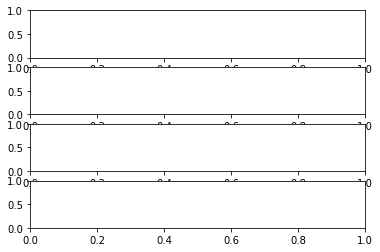

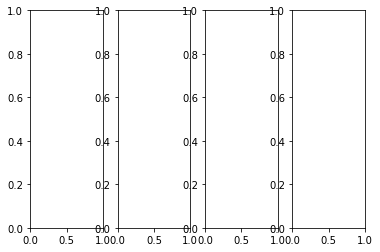